# Effect of straylight subtraction on MRS point source observations
The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.  
  
In this notebook we use the method of straylight subtraction (version 2) developed by Adrian Glauser and Polychronis Patapis at ETH Zurich (see MIRI-TN-00003-ETH-1.0_MRS_straylight). We check what the amount of calculated straylight is in data of an 800K BB point source observed during testing carried out at RAL (MIRI FM test campaign). This is done in multiple MRS bands (to try and determine the spectral variation of the straylight).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

from numpy import (where,diff,meshgrid,arange,maximum,sqrt,zeros_like,nonzero,isnan)
from astropy.convolution import convolve, Box2DKernel
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'CV2_data/LVL2/'

In [3]:
# initialize dictionaries
lambcens,centroid = {},{}
lambdaMaps,point_source_signal,straylight_imgs,xpos = {},{},{},{}

In [28]:
# point source centroiding
for band in ['1A']:
    print 'Band {}'.format(band)
    # Get data
    point_source_sci,point_source_bkg = mrsobs.CV_800K_BB_MRS_OPT_02_obs(lvl2path,band,campaign='CV2',pointing='P0',output='img')
    point_source_bkgsubtr = point_source_sci-point_source_bkg
    
    # load detector2cube (d2c) distortion maps
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
    sliceMap  = d2cMaps['sliceMap']     # map with slice IDs
    det_dims  = (1024,1032)             # pixel dimensions of the detector
    
    fringe_img,photom_img,pixsiz_img,psffits,specres_table = funcs.get_cdps(band,cdpDir,output='img')
    lambcens[band],lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
    
    if band[0] == '4': fit = '1D'
    else: fit = '2D'

    if band in ['1A','1B','1C']:
        centroid[band] = funcs.point_source_centroiding(band,point_source_bkgsubtr,d2cMaps,spec_grid=[lambcens[band],lambfwhms],fit=fit)
    elif band in ['2A','2B','2C']:
        centroid[band] = funcs.point_source_along_slice_centroiding(band,point_source_bkgsubtr,d2cMaps,spec_grid=[lambcens[band],lambfwhms])
    print ''
print 'DONE'

Band 3A

Band 3B

Band 3C


UnboundLocalError: local variable 'sci_idx' referenced before assignment

In [4]:
# straylight estimation
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    # Get data
    point_source_sci,point_source_bkg = mrsobs.CV_800K_BB_MRS_OPT_02_obs(lvl2path,band,campaign='CV2',pointing='P0',output='img')
    point_source_bkgsubtr = point_source_sci-point_source_bkg

    # load detector2cube (d2c) distortion maps
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
    sliceMap  = d2cMaps['sliceMap']     # map with slice IDs
    det_dims  = (1024,1032)             # pixel dimensions of the detector
    
    ypos,xpos[band] = funcs.detpixel_trace_compactsource(point_source_bkgsubtr,band,d2cMaps)
    
    # load kernel
    R=50;k=1
    w = funcs.Shepard2DKernel(R,k)
    
    #>mask where gap pixels are 1 and slice pixels are 0
    mask = zeros_like(sliceMap)
    mask[sliceMap == 0] = 1

    #>apply mask to science image
    img_gap = point_source_bkgsubtr*mask

    #> set pixels with signal less than zero to a signal of 0
    img_gap[img_gap<0] = 0

    #> smooth signal in gap pixels using a 2D box kernel of size 3
    img_gap = convolve(img_gap, Box2DKernel(3))

    #> reset sci pixels to 0
    img_gap*=mask

    #> convolve gap pixel img with weight kernel
    straylight = convolve(img_gap, w)

    #> normalize straylight flux by sum of weights
    norm_conv = convolve(mask, w)
    straylight /= norm_conv
    
    lambdaMaps[band]          = d2cMaps['lambdaMap']
    point_source_signal[band] = point_source_bkgsubtr
    straylight_imgs[band]     = straylight
print 'DONE'

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
DONE


<IPython.core.display.Javascript object>


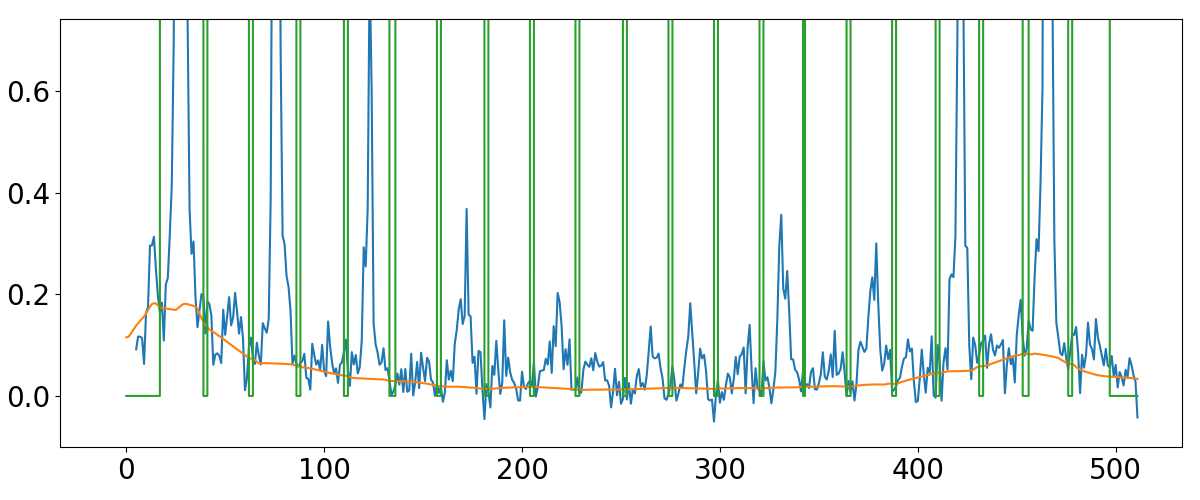

In [33]:
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format('1A'),path=d2cMapDir)
sliceMap  = d2cMaps['sliceMap']

plt.close('all')
plt.figure(figsize=(12,5))
plt.plot(point_source_signal['1A'][512,:512])
plt.plot(straylight_imgs['1A'][512,:512])
plt.plot(sliceMap[512,:512])
plt.ylim(-1,35)
plt.tight_layout()

<IPython.core.display.Javascript object>


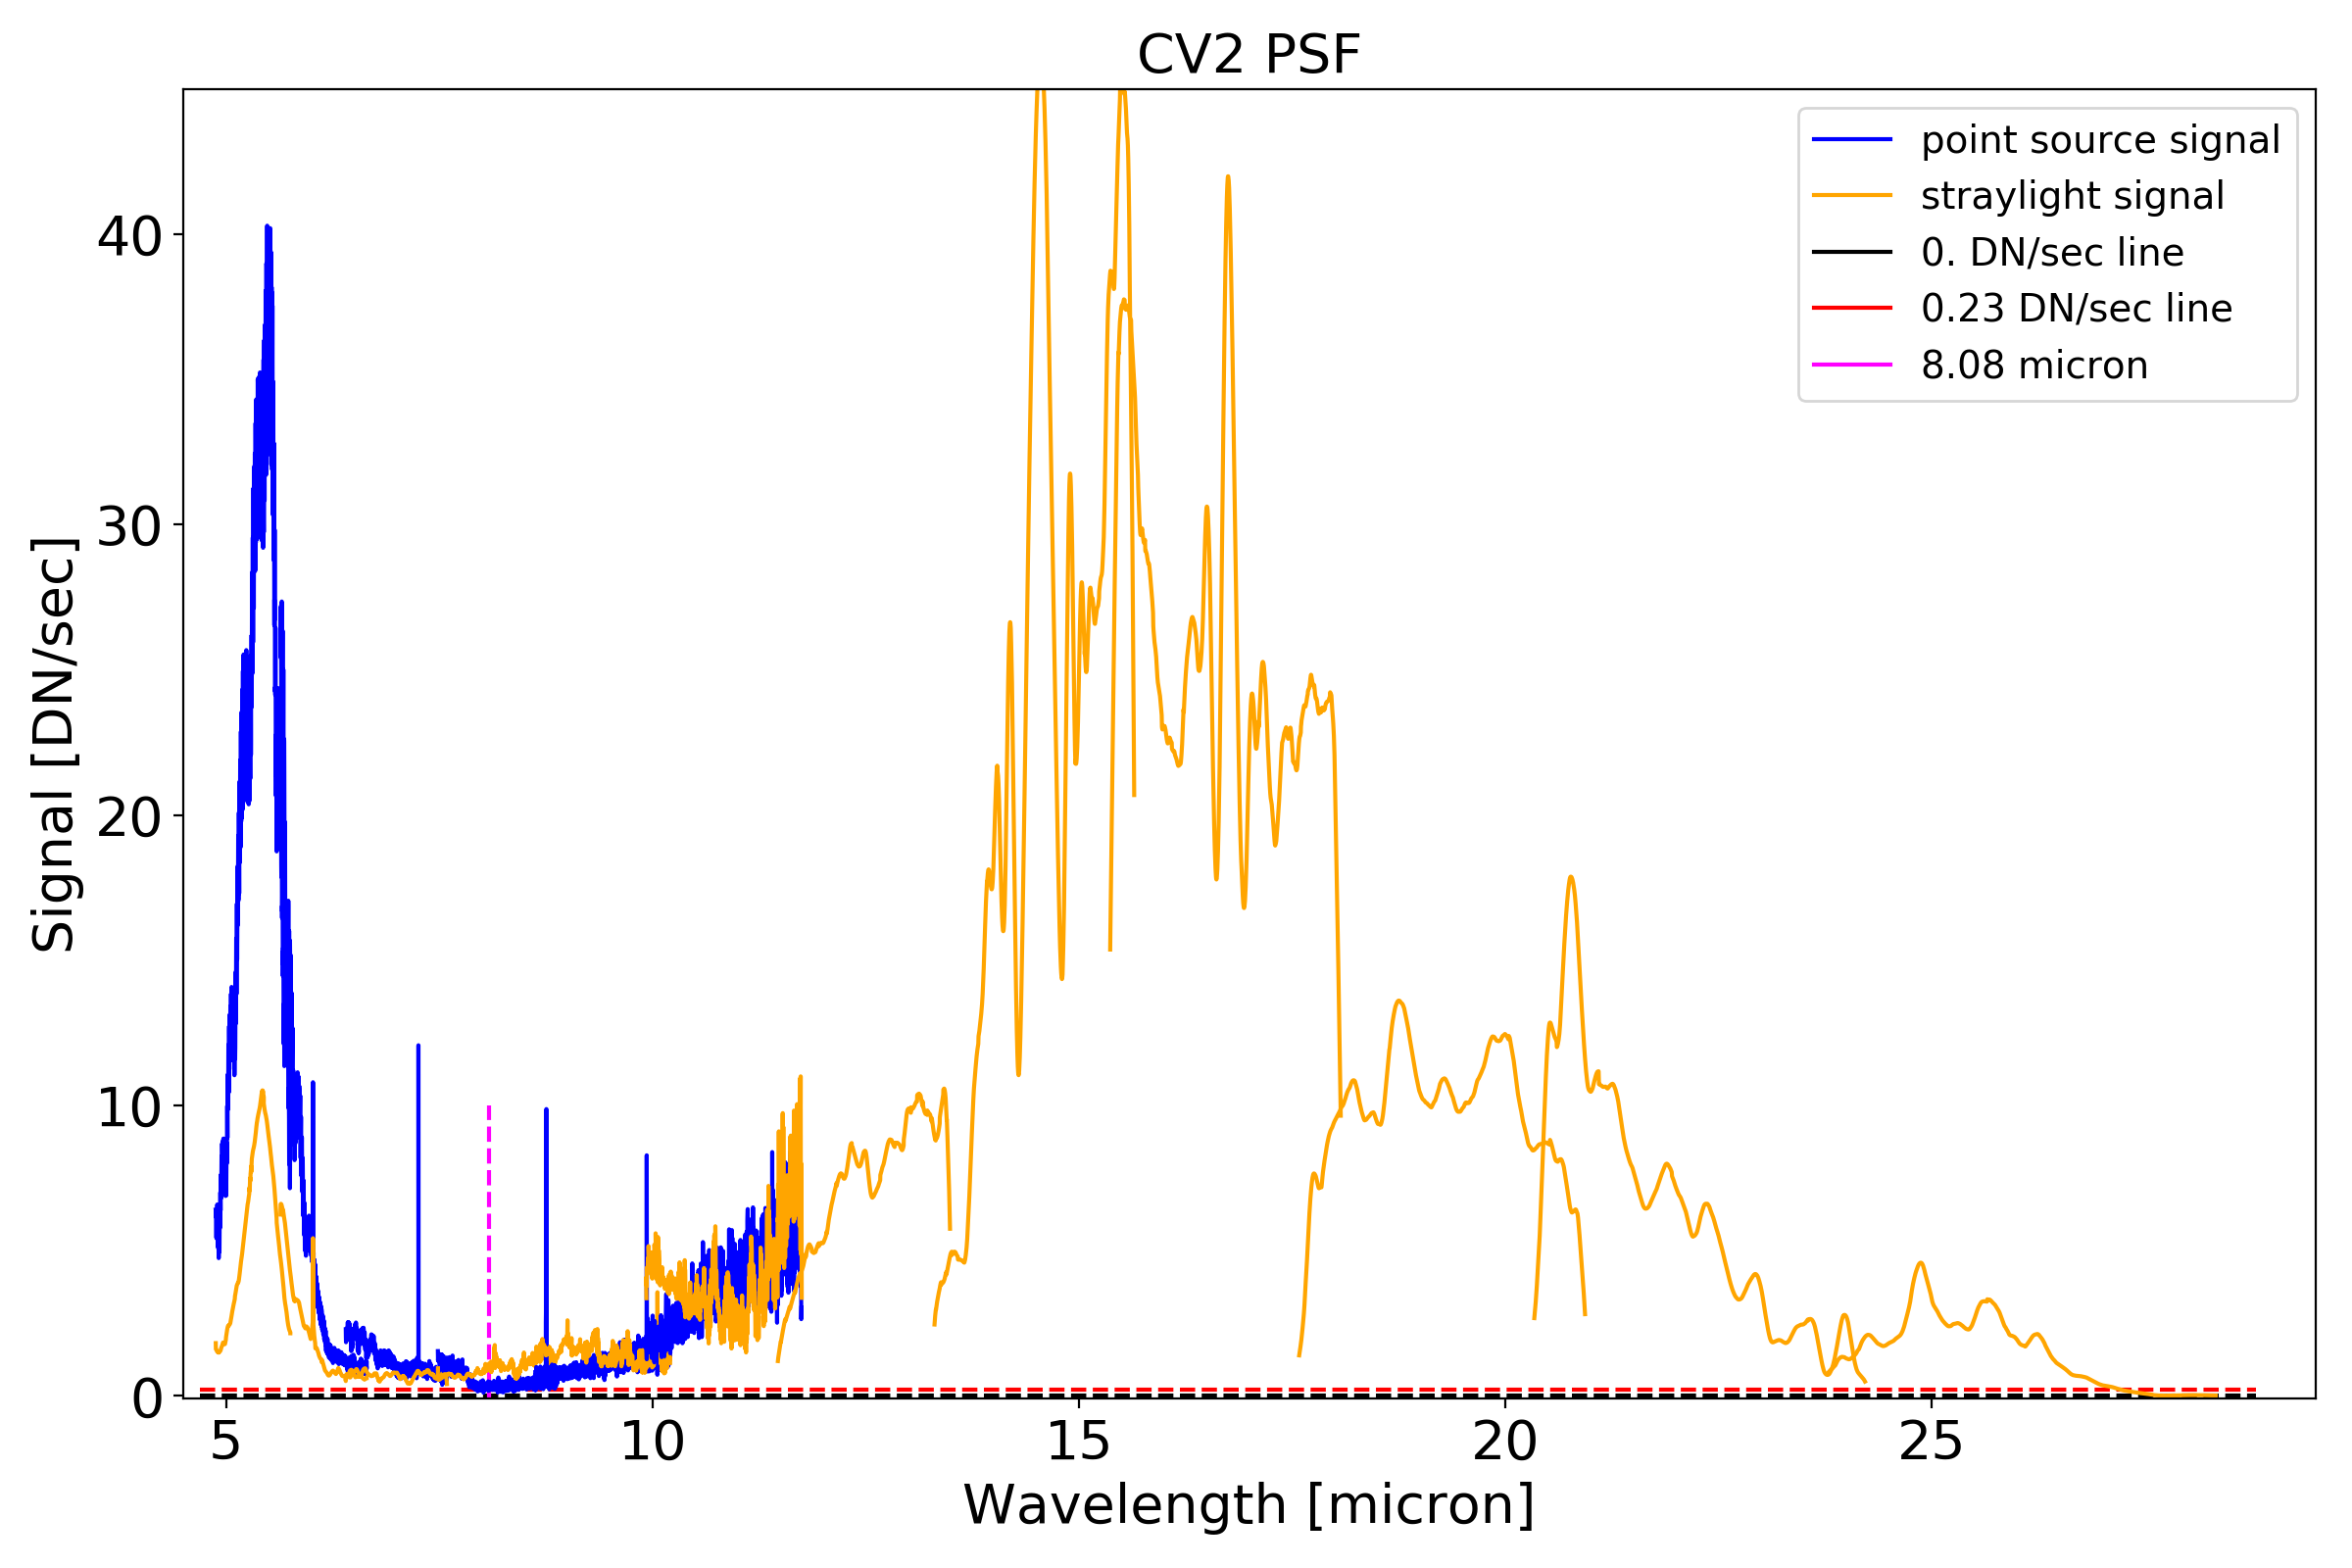

In [5]:
plt.figure(figsize=(12,8))
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']: # 
    if band[0] in ['1','2']:
        plt.plot(lambdaMaps[band][ypos,xpos[band]][nonzero(lambdaMaps[band][ypos,xpos[band]])],point_source_signal[band][ypos,xpos[band]][nonzero(lambdaMaps[band][ypos,xpos[band]])],'b')
        plt.plot(lambdaMaps[band][ypos,xpos[band]][nonzero(lambdaMaps[band][ypos,xpos[band]])],straylight_imgs[band][ypos,xpos[band]][nonzero(lambdaMaps[band][ypos,xpos[band]])]*50.,'orange')
    elif band[0] in ['3','4']:
        d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
        ypos_p,xpos_p = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
#         plt.plot(lambdaMaps[band][:,520][nonzero(lambdaMaps[band][:,520])],point_source_signal[band][:,520][nonzero(lambdaMaps[band][:,520])],'b')
        plt.plot(lambdaMaps[band][ypos_p,xpos_p][nonzero(lambdaMaps[band][ypos_p,xpos_p])],straylight_imgs[band][ypos_p,xpos_p][nonzero(lambdaMaps[band][ypos_p,xpos_p])],'orange')
plt.xlim(4.5)
plt.ylim(-0.1,45)
plt.hlines(0,4.7,28.8,'k',linestyle='dashed')
plt.hlines(0.23,4.7,28.8,'r',linestyle='dashed')
plt.vlines(8.08,-1,10,'magenta',linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.title('CV2 PSF')
legend_elements = [Line2D([0],[0],color='b',label='point source signal'),
                   Line2D([0],[0],color='orange',label='straylight signal'),
                   Line2D([0],[0],color='k',label='0. DN/sec line'),
                   Line2D([0],[0],color='r',label='0.23 DN/sec line'),
                   Line2D([0],[0],color='magenta',label='8.08 micron')]
plt.legend(handles=legend_elements,loc='upper right')
plt.tight_layout()

<IPython.core.display.Javascript object>


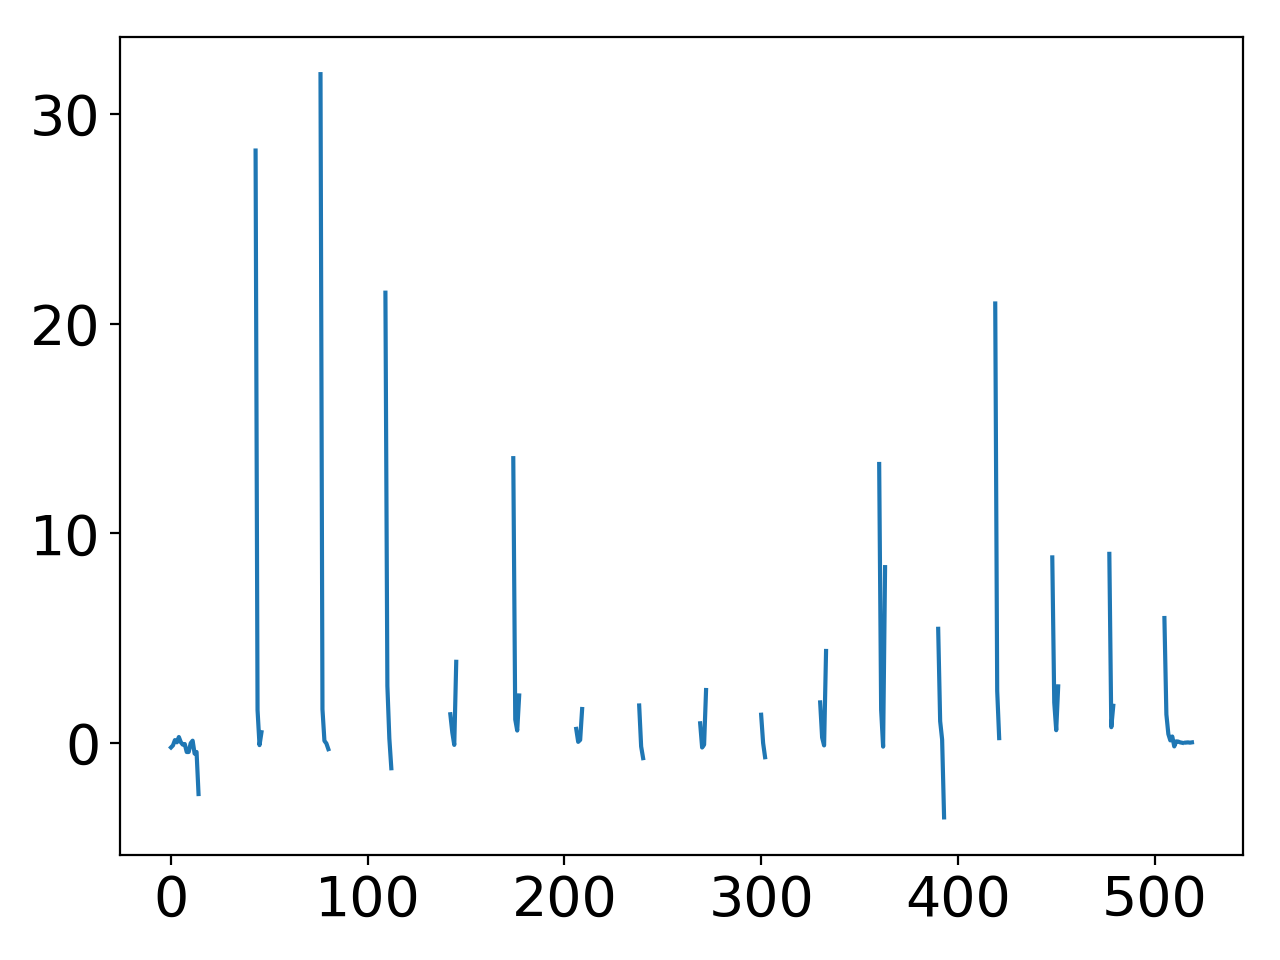

In [6]:
plt.figure()
plt.plot(point_source_signal['3B'][512,512:])
plt.tight_layout()

<IPython.core.display.Javascript object>


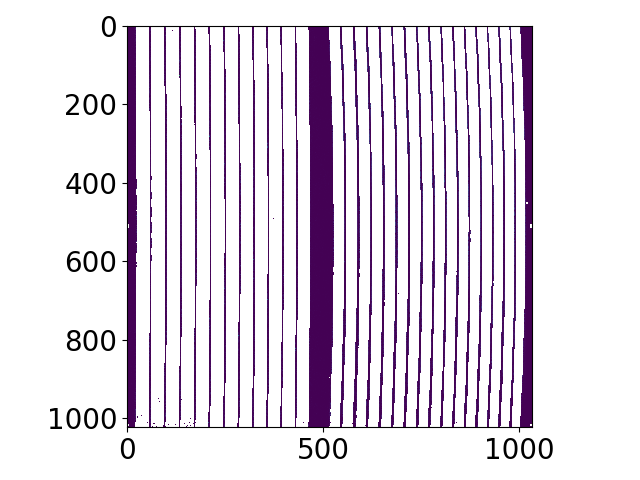

<IPython.core.display.Javascript object>


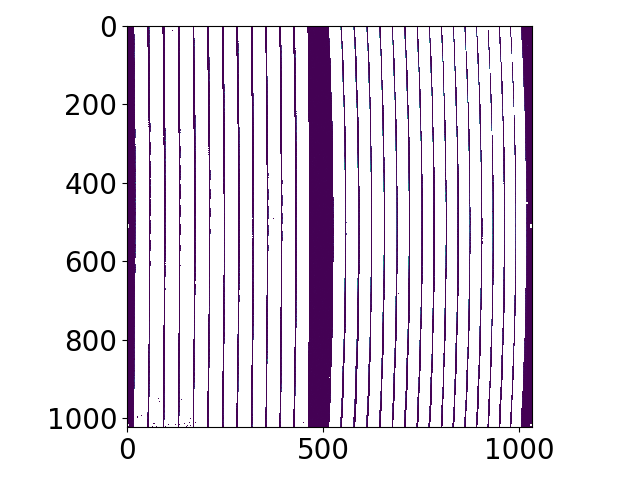

<IPython.core.display.Javascript object>


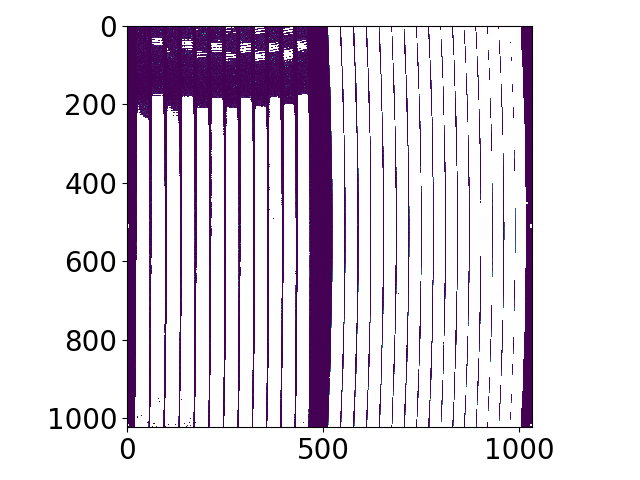

In [19]:
for band in ['3A','3B','3C']:
    plt.figure()
    plt.imshow(straylight_imgs[band],vmin=0)
    plt.tight_layout()